In [ ]:
# Goal: This program uses an artificial recurrent neural network called Long Short Term Memory (LSTM) to predict prices of a stock using the past stock price data.

In [1]:
# import
# data from
# https://finance.yahoo.com/quote/JPM/history?period1=1344124800&period2=1659657600&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true
!pip install yfinance
import math
import yfinance as y
import os
import json
import numpy as n
import pandas as p
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as t
t.style.use('fivethirtyeight')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 62 kB 416 kB/s 
  Attempting uninstall: requests
    Found existing installation: requests 2.23.0
    Uninstalling requests-2.23.0:
      Successfully uninstalled requests-2.23.0


In [2]:
# data acquistion
DATA_PATH = 'd.json'
if  os.path.exists(DATA_PATH):
    with open(DATA_PATH) as f:
      d_hist = p.read_json(DATA_PATH)
else:
    d = y.Ticker('JPM')
    d_hist = d.history(period='10y', interval='1d')
    d_hist.to_json(DATA_PATH)

# drop last 2 col
d_hist = d_hist.drop(columns=['Volume', 'Dividends', 'Stock Splits'])

# table
d_hist

# meta
d_hist.shape

(2515, 4)

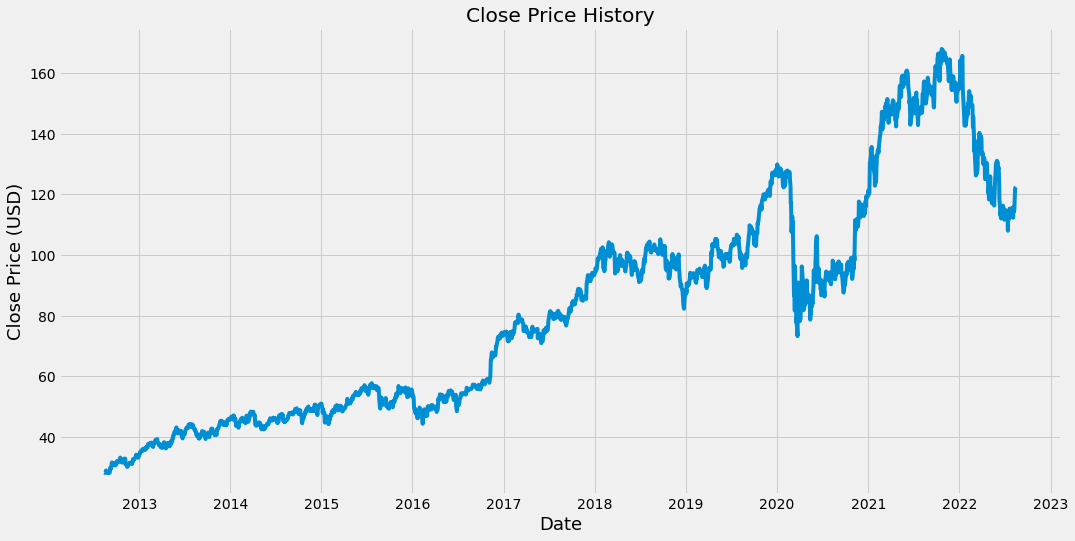

In [3]:
# close price history chart
t.figure(figsize=(16,8))
t.title('Close Price History')
t.xlabel('Date', fontsize=18)
t.ylabel('Close Price (USD)', fontsize=18)
t.plot(d_hist['Close'])
t.show()

In [4]:
# new dataframe with only 'Close' col
data = d_hist.filter(['Close'])

# convert to numpy array
dataset = data.values

# create training set
training_data_len = math.ceil(len(dataset)*.8)

training_data_len

2012

In [5]:
# scale
s = MinMaxScaler(feature_range=(0,1))
s_data = s.fit_transform(dataset)

s_data

array([[1.08395163e-03],
       [4.33586101e-04],
       [2.54733878e-03],
       ...,
       [6.58072159e-01],
       [6.72285249e-01],
       [6.74642210e-01]])

In [6]:
# create training dataset
# scaled
train_data = s_data[0:training_data_len, :]
# split x and y
x_train = []
y_train = []

for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i,0])
  y_train.append(train_data[i,0])
  if i <= 61:
    print(x_train)
    print(y_train)
    print()

[array([0.00108395, 0.00043359, 0.00254734, 0.00617883, 0.00504065,
       0.00178855, 0.00146332, 0.00178855, 0.00124654, 0.00216793,
       0.        , 0.00130069, 0.00059616, 0.00113816, 0.00970184,
       0.01300805, 0.0100812 , 0.0146341 , 0.01636845, 0.02439013,
       0.02531151, 0.02325188, 0.02363134, 0.02406494, 0.02357716,
       0.0215717 , 0.02346873, 0.01978305, 0.01810296, 0.02048772,
       0.01940366, 0.0220595 , 0.02178856, 0.02309895, 0.02834064,
       0.02774002, 0.02746696, 0.02593817, 0.02806759, 0.02986935,
       0.02724857, 0.03139821, 0.03385535, 0.03653068, 0.03483805,
       0.03107061, 0.02981492, 0.02566511, 0.02774002, 0.02752155,
       0.02473691, 0.02757615, 0.0339099 , 0.03161661, 0.03079758,
       0.0341283 , 0.02102409, 0.02058725, 0.02178851, 0.0215701 ])]
[0.018621738384379805]

[array([0.00108395, 0.00043359, 0.00254734, 0.00617883, 0.00504065,
       0.00178855, 0.00146332, 0.00178855, 0.00124654, 0.00216793,
       0.        , 0.00130069, 0.0

In [7]:
# convert x & y training sets to numpy arrays
x_train, y_train = n.array(x_train), n.array(y_train)

In [8]:
# reshape
x_train = n.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(1952, 60, 1)

In [9]:
# build LSTM model
m = Sequential()
m.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
m.add(LSTM(50, return_sequences=False))
m.add(Dense(25))
m.add(Dense(1))

In [10]:
# compile
m.compile(optimizer='adam', loss='mean_squared_error')

In [11]:
# train
m.fit(x_train, y_train, batch_size=1, epochs=1)

1952/1952 [==============================] - 48s 23ms/step - loss: 9.8503e-04


In [12]:
# create testing dataset
# create new array containing scaled values from index 291 to 7432
test_data = s_data[training_data_len-60:,:]
# test datasets
x_test = []
y_test = dataset[training_data_len:,:]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i,0])

In [13]:
# convert to numpy array
x_test = n.array(x_test)

In [14]:
# reshape
x_test = n.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [15]:
# get predicted price values
predictions = m.predict(x_test)
predictions = s.inverse_transform(predictions)

In [16]:
# get root mean squared error (RMSE)
rmse = n.sqrt(n.mean(predictions-y_test)**2)
rmse

2.1231980371190824

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


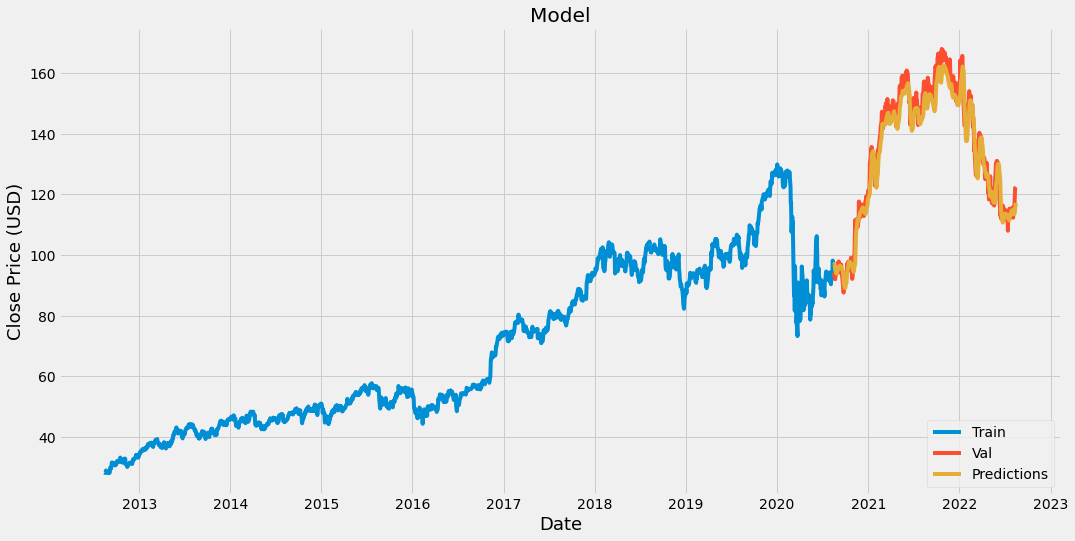

In [17]:
# plot
train = data[:training_data_len]
valid = data[training_data_len:]
valid['Predictions']=predictions

# visualize
t.figure(figsize=(16,8))
t.title('Model')
t.xlabel('Date', fontsize=18)
t.ylabel('Close Price (USD)', fontsize=18)
t.plot(train['Close'])
t.plot(valid[['Close', 'Predictions']])
t.legend(['Train', 'Val', 'Predictions'], loc='lower right')
t.show()

In [18]:
# show valid and predicted prices
valid

Close  Predictions
Date                               
2020-08-17   94.260223    96.870537
2020-08-18   92.946182    97.056786
2020-08-19   93.163620    96.698494
2020-08-20   92.048119    96.095398
2020-08-21   92.000839    95.258072
...                ...          ...
2022-08-09  115.379997   113.473328
2022-08-10  118.389999   113.696205
2022-08-11  120.139999   114.438637
2022-08-12  122.129997   115.613945
2022-08-15  122.459999   117.171341

[503 rows x 2 columns]

In [ ]:
# filter for Close
df = d_hist.filter(['Close'])

# get last 60 days
last_60d = df[-60:].values

# scale b/w 0 & 1
last_60d_s = s.transform(last_60d)

# create X_test
X_test = []

# append last 60d scaled
X_test.append(last_60d_s)

# convert to numpy array
X_test = n.array(X_test)

# reshape
X_test = n.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# get predicted scaled price
pred = m.predict(X_test)

# undo scaling
pred = s.inverse_transform(pred)
print(pred)

[[115.00357]]


In [ ]:
# print quote
d_hist

Open        High         Low       Close
2012-08-06   27.501396   27.926361   27.402743   27.546926
2012-08-07   27.751817   28.738345   27.751817   28.085718
2012-08-08   27.964297   28.442384   27.888411   28.199547
2012-08-09   27.865650   28.275437   27.766997   28.017422
2012-08-10   27.896002   28.078132   27.622812   28.055367
...                ...         ...         ...         ...
2022-08-01  114.500000  115.110001  113.070000  114.209999
2022-08-02  113.919998  114.400002  112.269997  112.430000
2022-08-03  113.449997  114.099998  111.709999  113.610001
2022-08-04  112.849998  113.320000  111.019997  112.360001
2022-08-05  112.529999  116.189903  112.050003  115.970001

[2517 rows x 4 columns]